In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())

Using TensorFlow backend.


In [2]:
import utils
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

In [5]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [7]:
# Adding GBLUR
x_train, x_train_noisy = utils.cifar10_gblur(x_train)
x_test, x_test_noisy = utils.cifar10_gblur(x_test)
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

5000/50000 images done!
10000/50000 images done!
15000/50000 images done!
20000/50000 images done!
25000/50000 images done!
30000/50000 images done!
35000/50000 images done!
40000/50000 images done!
45000/50000 images done!
50000/50000 images done!
Adding GBLUR done!
5000/10000 images done!
10000/10000 images done!
Adding GBLUR done!


In [8]:
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((250000, 32, 32, 3),
 (250000, 32, 32, 3),
 (50000, 32, 32, 3),
 (50000, 32, 32, 3))

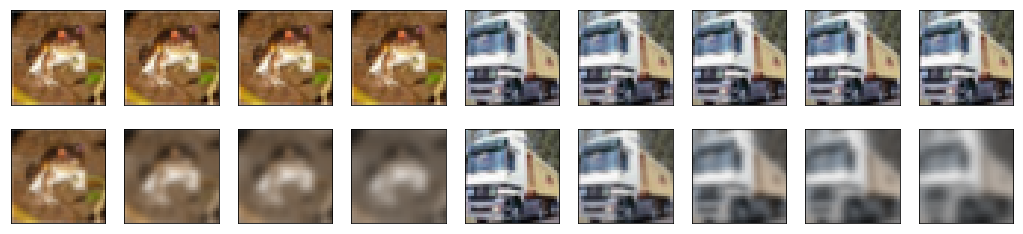

In [9]:
# Displaying noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
from keras.callbacks import TensorBoard
import sys

sys.stdout = open('cdA_gblur_output.txt', 'w')
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=False)])
sys.stdout = sys.__stdout__

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display distorted
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [1]:
################## Testing the model ##################

In [3]:
import utils
import numpy as np
import matplotlib.pyplot as plt

import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()
x_train.shape, x_test.shape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [16]:
x_test_noisy = utils.add_gblur(x_test, 1.0)

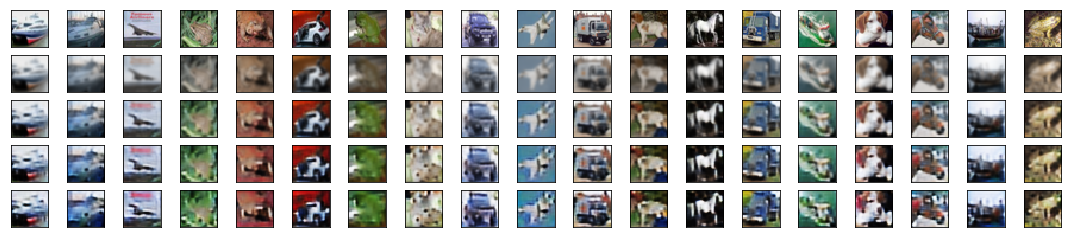

In [17]:
from keras.models import load_model
autoencoder = load_model('my_models/cdA_gblur.h5')
decoded_imgs = autoencoder.predict(x_test_noisy)
deblur_imgs1 = autoencoder.predict(decoded_imgs)
deblur_imgs2 = autoencoder.predict(deblur_imgs1)
no_vis = 5
n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n):
# display original
    ax = plt.subplot(no_vis, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# display distorted
    ax = plt.subplot(no_vis, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display reconstruction
    ax = plt.subplot(no_vis, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# deblured images 1
    ax = plt.subplot(no_vis, n, i + 3*n)
    plt.imshow(deblur_imgs1[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# deblured images 2
    ax = plt.subplot(no_vis, n, i + 4*n)
    plt.imshow(deblur_imgs2[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()